In [1]:
#Computing
from astropy.io import fits
import numpy as np
import math
import treecorr
import time
import random
import pyccl as ccl
import gc

#for masks:
#import healpy as hp
#import h5py as h5
#import healsparse as hs


#for saving:
import pickle

#for ploting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Math



cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



# data for test

In [2]:
"""
# eBOSS ELG
"""
path='/global/cfs/cdirs/des/william/BOSS_eBOSS/

# %%
hdul=fits.open(path+'eBOSS_ELG_clustering_data-SGC-vDR16.fits')
data=hdul[1].data
#print(data.columns)
ra_eboss_ELG_south=data['ra']
dec_eboss_ELG_south=data['dec']
z_eboss_ELG_south=data['z']
weight_eboss_ELG_south_sys=data['WEIGHT_SYSTOT']
weight_eboss_ELG_south_cp=data['WEIGHT_CP']
weight_eboss_ELG_south_noz=data['WEIGHT_NOZ']
weight_eboss_ELG_south=weight_eboss_ELG_south_sys*weight_eboss_ELG_south_cp*weight_eboss_ELG_south_noz

# %%
hdul=fits.open(path+'/eBOSS_ELG_clustering_random-SGC-vDR16.fits')
data=hdul[1].data
#print(data.columns)
ra_rand_eboss_ELG_south=data['ra']
dec_rand_eboss_ELG_south=data['dec']
z_rand_eboss_ELG_south=data['z']
weight_rand_eboss_ELG_south_sys=data['WEIGHT_SYSTOT']
weight_rand_eboss_ELG_south_cp=data['WEIGHT_CP']
weight_rand_eboss_ELG_south_noz=data['WEIGHT_NOZ']
weight_rand_eboss_ELG_south=weight_rand_eboss_ELG_south_sys*weight_rand_eboss_ELG_south_cp*weight_rand_eboss_ELG_south_noz




# The integrated 2-pt cross-corrfunction 

We evalute $w_{ru}(z_i)=\int_{\theta_{\rm min}}^{\theta_{\rm max}} {\rm d}\theta \, \frac{\theta^{\alpha}}{\int d\theta\, \theta^{\alpha}}\, \frac{D_rD_u-D_rR_u-R_rD_u+R_rR_u}{R_rR_u}(\theta)$, where the sample $r$ is distributed into $N_z$ bins: $z_i\pm \Delta z/2$

In [24]:
def w_ru(sample_ref, sample_unk, scale_range, z_range, Ntheta, Nz, Npatch, z_for_rand_ref, z_for_rand_unk,Eta_rand):
    '''
    Code to compute the cross-correlation of sample_ref with sample_unk, where sample_ref is sliced in Nz small z-bins (with min and max given by z_range)
    -------------------------------------
    Outputs:
    Wz: is a Nz x Nalpha array, where Nz is the number of z bins, and Nalpha the number of scale weighting
    Thus Wz[iz][ialpha] is the value for wxx for the z-bin iz, and the scale weighting ialpha
    
    Err is a Nz x Nalpha uncertainty array associated to WZ.

    Multi_cov is the Nz x Njkk x Nalpha array usefull to compute the full covariance!!

    For std tests, use directly WZ and Err. Usually redshift covariance is negligible.
    -------------------------------------
    Inputs:
    sample_..: array ['name', option] with 'name'name of the sample, option can be the TB phz cut if if name='photo' for example
    
    scale_range is an array = [convention,scale_min,scale_max], with convention ='rp' or 'theta', with scale_min/max IN ARCMIN or MPC
    z_range is an array = [zmin,zmax]

    Ntheta is the number of theta-bins (default use 10)
    Nz is the number of z-bins
    Npatch the number of Jkk patches to evaluate the cov
    
    z_for_rand==True means there are redshifts for randoms
    Eta_rand is how many more randoms you want, to evaluate the DD/RR counts
    -------------------------------------
    '''
    print('evaluate the cross-corr of ', sample_ref, ' with ',sample_unk)
    print('for sample_x distributed over',z_range[0], '<z<',z_range[1],'  in ', Nz, ' slices')

    zmin=z_range[0]
    zmax=z_range[1]
    dz=(zmax-zmin)/Nz
        
    # You can add other options, with another elif, eg with sample_x=='spec'
    if sample_ref[0]=='Euclid_spectro':
        ra_ref =1
        dec_ref =1
        z_ref =1
        w_ref =  1#np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand_ref =1
        dec_rand_ref =1
        w_rand_ref = 1
        if z_for_rand_ref==True:
            z_rand_ref=1      
    elif sample_ref[0]=='eBOSS ELG':
        ra_ref =ra_eboss_ELG_south
        dec_ref =dec_eboss_ELG_south
        z_ref =z_eboss_ELG_south
        w_ref =  weight_eboss_ELG_south#np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand_ref =ra_rand_eboss_ELG_south
        dec_rand_ref =dec_rand_eboss_ELG_south
        w_rand_ref =  weight_rand_eboss_ELG_south
        if z_for_rand_ref==True:
            z_rand_ref=z_rand_eboss_ELG_south
    else:
        print('sample_ref not included in the code')

    
    if sample_unk[0]=='Euclid_photo':
        ra_unk =1
        dec_unk =1
        z_unk =1
        w_unk = np.array([1 for i in ra_unk]) #if you do have weights, replace this array
        
        ra_rand_unk =1
        dec_rand_unk =1
        w_rand_unk =  np.array([1 for i in ra_rand])
        if z_for_rand_unk==True:
            z_rand_unk=1
    elif sample_unk[0]=='eBOSS ELG':
        #Some z-cuts
        sel_elg=((z_eboss_ELG_south>sample_unk[1])&(z_eboss_ELG_south<sample_unk[2]))
        
        ra_unk =ra_eboss_ELG_south[sel_elg]
        dec_unk =dec_eboss_ELG_south[sel_elg]
        z_unk =z_eboss_ELG_south[sel_elg]
        w_unk =  weight_eboss_ELG_south[sel_elg]#np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand_unk =ra_rand_eboss_ELG_south
        dec_rand_unk =dec_rand_eboss_ELG_south
        w_rand_unk =  weight_rand_eboss_ELG_south
        if z_for_rand_unk==True:
            z_rand_unk=z_rand_eboss_ELG_south
        
        if z_for_rand_ref==True:
            sel_rand_unk_subbin=((z_rand_unk>=sample_unk[1])&(z_rand_unk<sample_unk[2]))
        else:
            sel_rand_unk_subbin=np.array([True for r in ra_rand_unk])
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand_unk[sel_rand_unk_subbin])
        Nrand=Eta_rand*len(ra_unk)
        Index=random.choices(range(Ntot), k=Nrand)
        ra_rand_unk =ra_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]
        dec_rand_unk =dec_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]
        w_rand_unk =  weight_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]
    else:
        print('sample_unk not included in the code')

    print(len(ra_ref) ,' ref galaxies ')
    print(len(ra_rand_ref ) ,'ref randoms ')
    print(len(ra_unk) ,' unk galaxies ')
    print(len(ra_rand_unk ) ,'unk randoms ')
    
    Wz=[]
    Cov=[]
    Err=[]
    Multi_cov=[]
    
    #create unk catalog, and use the same Jkk patches for the other cat
    cat_rand_unk = treecorr.Catalog(ra=ra_rand_unk,dec=dec_rand_unk,w=w_rand_unk,ra_units='degrees',dec_units='degrees',npatch=Npatch)
    cat_unk = treecorr.Catalog(ra=ra_unk,dec=dec_unk,w=w_unk,ra_units='degrees',dec_units='degrees',patch_centers=cat_rand_unk.patch_centers)
    
    for iz in range(Nz):
        zmean_i=zmin+(iz+0.5)*dz
        zmin_i=zmin+(iz)*dz
        zmax_i=zmin+(iz+1)*dz
        
        if scale_range[0]=='theta':
            theta_min=scale_range[1]/60 # arcmin to degree
            theta_max=scale_range[2]/60 # arcmin to degree
        elif scale_range[0]=='rp':
            theta_min=scale_range[1]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
            theta_max=scale_range[2]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
        else:
            print('error scale conv')
            return 0,0,0

        print('zi=',round(zmean_i,3),' dz=',round(dz,3))
        
        sel_ref_subbin=((z_ref>=zmin_i)&(z_ref<zmax_i))
        cat_ref_subbin=treecorr.Catalog(ra=ra_ref[sel_ref_subbin],dec=dec_ref[sel_ref_subbin],w=w_ref[sel_ref_subbin],ra_units='degrees',dec_units='degrees',patch_centers=cat_rand_unk.patch_centers)
        

        # Do we have z for randoms: 
        if z_for_rand_ref==True:
            sel_rand_ref_subbin=((z_rand_ref>=zmin_i)&(z_rand_ref<zmax_i))
        else:
            sel_rand_ref_subbin=np.array([True for r in ra_rand_ref])
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand_ref[sel_rand_ref_subbin])
        Nrand=Eta_rand*len(ra_ref[sel_ref_subbin])
        Index=random.choices(range(Ntot), k=Nrand)
        
        
        ra_rand_ref_select=ra_rand_ref[sel_rand_ref_subbin][Index]
        dec_rand_ref_select=dec_rand_ref[sel_rand_ref_subbin][Index]
        w_rand_ref_select=w_rand_ref[sel_rand_ref_subbin][Index]
    
        cat_rand_ref_subbin=treecorr.Catalog(ra=ra_rand_ref_select,dec=dec_rand_ref_select,w=w_rand_ref_select,ra_units='degrees',dec_units='degrees', patch_centers=cat_rand_unk.patch_centers)
    
        w_ru  = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        rr_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        dr_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        rd_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)

        #Now I use r as a name instead of theta
        rlist=w_ru.rnom
        redges=w_ru.right_edges-w_ru.left_edges
        #print(rlist)
        #print(redges)
        def integ_wru(w1):
            '''
            integrate w1 over theta, with different scales weighting, defined by List_alpha:
            W(theta)=theta**alpha/norm
            '''
            List_alpha=[-1,0,1]
            Results_alpha=[]
            Noweight=w1
            for alpha in  List_alpha:
                w1b=0
                norm=0
                for ir in range(len(w1)):
                    w1b+=w1[ir]*rlist[ir]**alpha*redges[ir]
                    norm+=rlist[ir]**alpha*redges[ir]
                Results_alpha.append(w1b/norm)

            return np.array(Results_alpha)
            
            
        rr_ru.process(cat_rand_ref_subbin,cat_rand_unk)
        dr_ru.process(cat_ref_subbin,cat_rand_unk)
        rd_ru.process(cat_rand_ref_subbin,cat_unk)
        
        w_ru.process(cat_ref_subbin,cat_unk)
        w_ru.calculateXi(rr=rr_ru,dr=dr_ru,rd=rd_ru)
         
        my_funct = lambda corrs: integ_wru(corrs[0].xi)
        corrs = [w_ru]
            
        ratio = my_funct(corrs)  
        cov = treecorr.estimate_multi_cov(corrs, 'jackknife', func=my_funct)
        multi_cov=treecorr.build_multi_cov_design_matrix(corrs,'jackknife', func=my_funct, comm=None)
        
        Wz.append(ratio)
        Cov.append(cov)
        Err.append([np.sqrt(cov[i][i]) for i in range(np.size(cov,0))])
        Multi_cov.append(multi_cov[0])
        
        del(cat_ref_subbin)
        del(cat_rand_ref_subbin)
        gc.collect()
    return(Wz,Err,Multi_cov)

    

# Plots

In [27]:
A0,B0,C0=w_ru(sample_ref=['eBOSS ELG'], sample_unk=['eBOSS ELG',0.7,0.77], scale_range=['rp',1.5,5], z_range=[0.6,0.85], Ntheta=10, Nz=5, Npatch=100, z_for_rand_ref=True,z_for_rand_unk=True, Eta_rand=5)


evaluate the cross-corr of  ['eBOSS ELG']  with  ['eBOSS ELG', 0.7, 0.77]
for sample_x distributed over 0.6 <z< 0.85   in  5  slices
89967  ref galaxies 
3609460 ref randoms 
18136  unk galaxies 
90680 unk randoms 
zi= 0.625  dz= 0.05
zi= 0.675  dz= 0.05
zi= 0.725  dz= 0.05
zi= 0.775  dz= 0.05
zi= 0.825  dz= 0.05


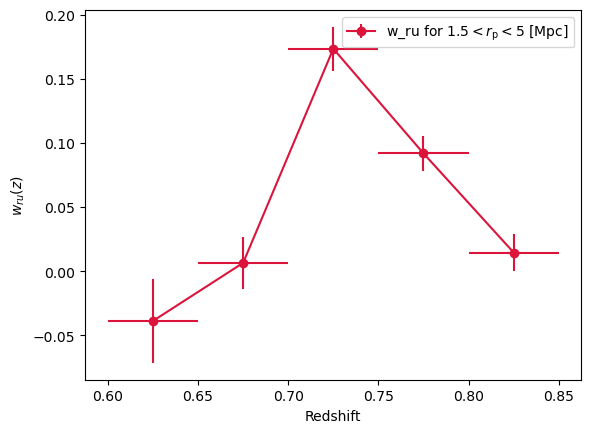

In [31]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{ru}(z)$')

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins


plt.errorbar(Z5, [A0[i][ialpha] for i in range(5)],xerr=[0.025 for i in range(5)],yerr=[B0[i][ialpha] for i in range(5)],color='crimson',marker='o',label=r'w_ru for $1.5<r_{\rm p}<5$ [Mpc]')

plt.legend()

In [32]:
w_rr=np.array([0.359, 0.353, 0.247, 0.285, 0.296])# cf A2 of the Auto-corr code
w_uu=np.copy(w_rr)# As u=r for our test....

Lets get the n(z) with a M5 bias correction, and compare with the truth


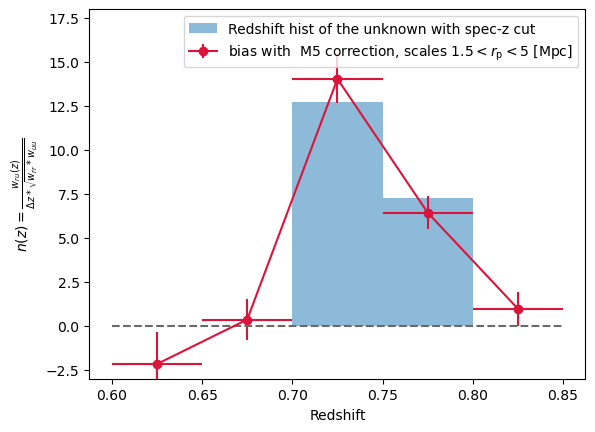

In [69]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$n(z)=\frac{w_{ru}(z)}{\Delta z *\sqrt{w_{rr}*w_{uu}}}$' )

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins

plt.errorbar(Z5, [A0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05 for i in range(5)],xerr=[0.025 for i in range(5)],yerr=[B0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05  for i in range(5)],color='crimson',marker='o',label=r'bias with  M5 correction, scales $1.5<r_{\rm p}<5$ [Mpc]')
plt.plot([0.6,0.85],[0,0],linestyle='--',color='dimgrey')

#plt.fill_between([0.7,0.77],[-3,-3],[18,18],label='spec-z cut on the unknown sample',alpha=0.5)

sel_elg=((z_eboss_ELG_south>0.7)&(z_eboss_ELG_south<0.77))
z_unk =z_eboss_ELG_south[sel_elg]
plt.hist(z_unk,bins=Z5-0.025,density=True,alpha=0.5,label='Redshift hist of the unknown with spec-z cut')

plt.ylim(-3,18)
plt.legend()
print('Lets get the n(z) with a M5 bias correction, and compare with the truth')


In [65]:
print('norm of the n(z) measured', 0.05*np.sum([max(0,A0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05) for i in range(5)]) )
print('as we use M5 correction, this should be close to 1')
print('all good')

norm of the n(z) measured 1.0912140678925155
as we use M5 correction, this should be close to 1
all good


### this is how to compute the redshift-covariance matrix from multi_cov returned by the cov....

In [55]:
Nz=5
Nalpha=3
Njkk=100

C_mat=C0
w_wz1=[]
Cov_wz1=[]
Err_wz1=[]
for ialpha in range(Nalpha):
    D0=np.array([[C_mat[iz][jk][ialpha] for jk in range(Njkk)]for iz in range(Nz)],dtype=np.float64)

    w_wz1.append(np.array([1/Njkk*np.sum(D0[jz]) for jz in range(Nz)],np.float64))
    Cov_wz1.append(np.array([[ ( Njkk-1)/Njkk* np.sum((D0[imat] - w_wz1[ialpha][imat]) * (D0[jmat] - w_wz1[ialpha][jmat])) for jmat in range(Nz)] for imat in range(Nz)],np.float64))    
    Err_wz1.append([np.sqrt(Cov_wz1[ialpha][i][i]) for i in range(Nz)])
    

In [56]:
#first dim in Nalpha, then Nz
print(np.shape(w_wz1))
print(np.shape(Cov_wz1))

(3, 5)
(3, 5, 5)


These two should match


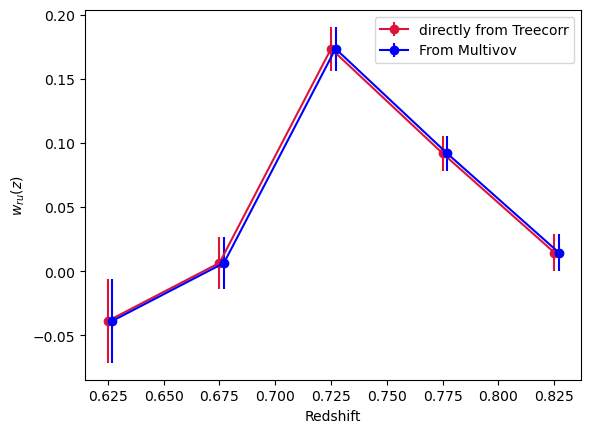

In [66]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{ru}(z)$')

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins


plt.errorbar(Z5, [A0[i][ialpha] for i in range(5)],yerr=[B0[i][ialpha] for i in range(5)],color='crimson',marker='o',label=r'directly from Treecorr')
plt.errorbar(Z5+0.002, w_wz1[ialpha],yerr=Err_wz1[ialpha],color='blue',marker='o',label=r'From Multivov')

plt.legend()
print('These two should match')